<h1> Email Spam Filtering using Naive Bayes Algorithm</h1>

In [1]:
#Import all the Necessary Libraries
import os
import email
import numpy as np
from sklearn.model_selection import train_test_split
from email import policy, parser
from bs4 import BeautifulSoup
from html import unescape
from collections import Counter
from scipy.sparse import csr_matrix
import urlextract
import re
import nltk
import scipy
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
SPAM_DIR = "spam"
HAM_DIR = "easy_ham"
spam_filenames = [filename for filename in os.listdir(SPAM_DIR)]
ham_filenames = [filename for filename in os.listdir(HAM_DIR)]

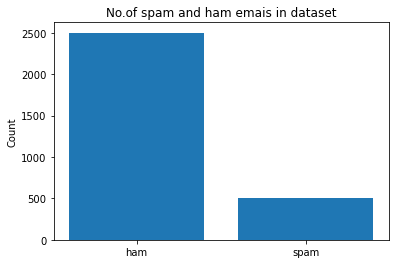

In [3]:
labels = ['ham', 'spam']
counts = [len(ham_filenames), len(spam_filenames)]
ypos = np.arange(len(labels))
plt.bar(ypos, counts)
plt.xticks(ypos, labels)
plt.ylabel("Count")
plt.title("No.of spam and ham emais in dataset")
plt.show()

<h4> Using Python's email module to parse these emails </h4>

In [4]:
def load_email(is_spam, filename):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(directory, filename), "rb") as file:
        return parser.BytesParser(policy = policy.default).parse(file)

In [5]:
ham_emails = [load_email(False, name) for name in ham_filenames]
spam_emails = [load_email(True, name) for name in spam_filenames]

In [6]:
ham_emails[0].get_content().strip()

'Date:        Wed, 21 Aug 2002 10:54:46 -0500\n    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>\n    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>\n\n\n  | I can\'t reproduce this error.\n\nFor me it is very repeatable... (like every time, without fail).\n\nThis is the debug log of the pick happening ...\n\n18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}\n18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury\n18:19:04 Ftoc_PickMsgs {{1 hit}}\n18:19:04 Marking 1 hits\n18:19:04 tkerror: syntax error in expression "int ...\n\nNote, if I run the pick command by hand ...\n\ndelta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury\n1 hit\n\nThat\'s where the "1 hit" comes from (obviously).  The version of nmh I\'m\nusing is ...\n\ndelta$ pick -version\npick -- nmh-1.0.4 [compiled on fuchsia.cs.mu

In [7]:
spam_emails[2].get_content().strip()

"1) Fight The Risk of Cancer!\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n3) Get the Child Support You Deserve - Free Legal Advice\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n4) Join the Web's Fastest Growing Singles Community\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n5) Start Your Private Photo Album Online!\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\nHave a Wonderful Day,\nOffer Manager\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417"

<h4>Emails contain plain text, html, images and some other attachments

In [8]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [9]:

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [10]:
structures_counter(ham_emails).most_common()

[('text/plain', 2409),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [11]:
structures_counter(spam_emails).most_common()

[('text/plain', 219),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [12]:
X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

<ipython-input-12-a4bf27d20c43>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(ham_emails + spam_emails)


<h4> Using BeautifulSoup Library to convert html into plain text

In [13]:
def html_to_plain_text(html):
    soup = BeautifulSoup(html)
    text = soup.get_text(separator = '\n', strip = True)
    text = text.replace('\n', " ")
    text = unescape(text)
    text = text.replace("  ", "")
    text = text.replace("_", "")
    return text

In [14]:
html_spam_emails = [email for email in spam_emails if get_email_structure(email) == "text/html"]

In [15]:
html_spam_emails[0].get_content().strip()[:1000]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n<HTML><HEAD>\n<META content="text/html; charset=windows-1252" http-equiv=Content-Type>\n<META content="MSHTML 5.00.2314.1000" name=GENERATOR></HEAD>\n<BODY><!-- Inserted by Calypso -->\n<TABLE border=0 cellPadding=0 cellSpacing=2 id=_CalyPrintHeader_ rules=none \nstyle="COLOR: black; DISPLAY: none" width="100%">\n  <TBODY>\n  <TR>\n    <TD colSpan=3>\n      <HR color=black noShade SIZE=1>\n    </TD></TR></TD></TR>\n  <TR>\n    <TD colSpan=3>\n      <HR color=black noShade SIZE=1>\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso --><FONT \ncolor=#000000 face=VERDANA,ARIAL,HELVETICA size=-2><BR></FONT></TD></TR></TABLE><!-- End Calypso --><FONT color=#ff0000 \nface="Copperplate Gothic Bold" size=5 PTSIZE="10">\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=#ff0000 \nface="Copperplate Gothic Bold" size=5 PTSIZE="10">\n<CENTER>Why Spend More Than You Have To?\n<CENTER><FONT co

In [16]:
html_to_plain_text(html_spam_emails[2].get_content())

'Dear ricardo1 , COST EFFECTIVE Direct Email Advertising Promote Your Business For As Low As $50 Per 1 Million Email Addresses MAXIMIZE YOUR MARKETING DOLLARS! Complete and fax this information form to 309-407-7378. A Consultant will contact you to discuss your marketing needs. NAME: COMPANY: ADDRESS: CITY: STATE: PHONE: E-MAIL: WEBSITE: (Not Required)    * COMMENTS: (Provide details, pricing, etc. on the products and services you wish to market)     [247(^(PO1:KJ)8J7BJK9^":}H&*TG0BK5NKIYs5]'

In [17]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content.replace("_", "")
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [18]:
print(email_to_text(html_spam_emails[2]))

Dear ricardo1 , COST EFFECTIVE Direct Email Advertising Promote Your Business For As Low As $50 Per 1 Million Email Addresses MAXIMIZE YOUR MARKETING DOLLARS! Complete and fax this information form to 309-407-7378. A Consultant will contact you to discuss your marketing needs. NAME: COMPANY: ADDRESS: CITY: STATE: PHONE: E-MAIL: WEBSITE: (Not Required)    * COMMENTS: (Provide details, pricing, etc. on the products and services you wish to market)     [247(^(PO1:KJ)8J7BJK9^":}H&*TG0BK5NKIYs5]


In [19]:
stemmer = nltk.PorterStemmer()
url_extractor = urlextract.URLExtract()

<h4> Convert Emails to word Counters using a custom Transformer

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = nltk.PorterStemmer()
        self.url_extractor = urlextract.URLExtract()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            text = text.lower()
            urls = url_extractor.find_urls(text)
            for url in urls:
                text = text.replace(url, " URL ")
            text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            text = re.sub(r'\W+', ' ', text)
            word_counts = Counter(text.split())
            stemmed_word_counts = Counter()
            for word, count in word_counts.items():
                stemmed_word = stemmer.stem(word)
                stemmed_word_counts[stemmed_word] += count
            X_transformed.append(stemmed_word_counts)
        return np.array(X_transformed)

In [21]:
X_sample_test = EmailToWordCounterTransformer().fit_transform(X_train[:3])

In [22]:
X_sample_test[1]

Counter({'onc': 1,
         'upon': 1,
         'a': 9,
         'time': 3,
         'angl': 1,
         'wrote': 1,
         'when': 1,
         'i': 14,
         'went': 1,
         'all': 5,
         'open': 1,
         'sourc': 1,
         'stop': 1,
         'use': 5,
         'my': 5,
         'old': 3,
         'partion': 2,
         'app': 2,
         'partit': 5,
         'magic': 1,
         'for': 4,
         'the': 10,
         'rhnumber': 2,
         'instal': 6,
         'fip': 1,
         'coupl': 1,
         'then': 3,
         'extnumb': 1,
         'came': 1,
         'out': 1,
         'and': 10,
         'commerci': 1,
         'is': 4,
         'real': 1,
         'so': 5,
         'ask': 1,
         'what': 1,
         'os': 1,
         'softwar': 1,
         'can': 7,
         'non': 1,
         'destruct': 2,
         'repartit': 1,
         'hd': 1,
         'put': 3,
         'home': 4,
         'on': 3,
         'seper': 1,
         'now': 1,
         'part':

<h4> Convert word Vectors to a matrix of TF-IDF features

In [23]:
class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [24]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_sparce_matrix = vocab_transformer.fit_transform(X_sample_test)
X_sparce_matrix

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 31 stored elements in Compressed Sparse Row format>

In [25]:
X_sparce_matrix.toarray()

array([[143,   6,   6,  21,   0,   3,   2,   2,   2,   0,   2],
       [321,  10,  10,   7,  14,  11,  11,   9,   5,   7,   3],
       [125,   9,   5,   1,   6,   2,   1,   1,   5,   3,   3]],
      dtype=int32)

In [26]:
vocab_transformer.vocabulary

{'the': 1,
 'and': 2,
 'number': 3,
 'i': 4,
 'to': 5,
 'you': 6,
 'a': 7,
 'it': 8,
 'can': 9,
 'list': 10}

<h4> Build a pipeline to transform the Dataset

In [27]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [28]:
from sklearn.naive_bayes import MultinomialNB

In [29]:
naive_bayes_clf = MultinomialNB()
scores = cross_val_score(naive_bayes_clf,
                         X_train_transformed,
                         y_train,
                         cv = 5,
                         scoring = 'accuracy',
                        n_jobs = -1)

In [30]:
print(scores)
print(scores.mean())

[0.97297297 0.975      0.98541667 0.97916667 0.97916667]
0.9783445945945946


In [31]:
y_pred = cross_val_predict(naive_bayes_clf, X_train_transformed, y_train, cv = 3)
conf_mat = confusion_matrix(y_train, y_pred)
conf_mat

array([[1976,   16],
       [  36,  373]], dtype=int64)

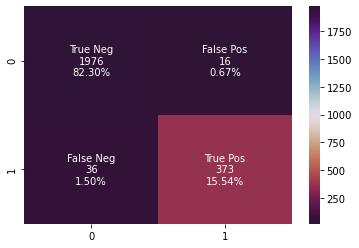

In [32]:
#Heatmap for confusion Matrix

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='twilight_shifted_r')
plt.show()

In [33]:
print("Precision: {:.2f}%".format(100 * precision_score(y_train, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_train, y_pred)))
print("F1-Score: {:.2f}%".format(100 * f1_score(y_train, y_pred)))

Precision: 95.89%
Recall: 91.20%
F1-Score: 93.48%


In [34]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label = "Precission")
    plt.plot(thresholds, recalls[:-1], 'g-', label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "upper left")
    plt.ylim([0, 1])

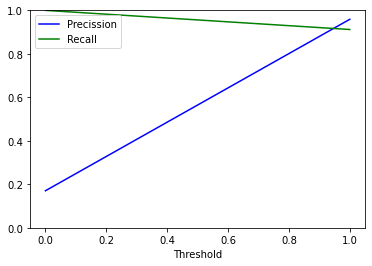

In [36]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

<h4> Evaluation on Test Dataset

In [37]:
X_test_transformed = preprocess_pipeline.transform(X_test)

naive_bayes_clf.fit(X_train_transformed, y_train)
y_pred = naive_bayes_clf.predict(X_test_transformed)
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Accuracy: 97.84%
Precision: 94.38%
Recall: 91.30%
